In [4]:
import glob
from collections import defaultdict

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import palettable
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import colors
from networkx.drawing.nx_agraph import graphviz_layout
from scipy.cluster.hierarchy import leaves_list, linkage
from scipy.spatial.distance import pdist, squareform
from scripts import aesthetics
from scripts import manuscript_colors as mc
from scripts import tree

aesthetics.activate_paper_rcParams("illustrator")

import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

__Note:___ This notebook will _not_ run with the conda environment detailed in `README.md`. This has to do with `graphviz` and its pretty restrictive version requirements. I have found that this notebook is generally easy to run with the most updated version of Python and by installing packages as necessary with `pip`. Some light googling and packaging control may be required to avoid errors with `graphviz`.

# Make Tree Figures

In this notebook, we make the SV "tree hierarchy" figures that are present in figure 4 and figure 6. These trees show the hierarchical nature of the categories.

They are, however, fairly difficult to make. The plotting code in this notebook is admittedly opaque, and it may not be fully reproducible on other machines.

## Read in data

Read in necessary data, as in other notebooks.

In [5]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/cwas/svs-in-categories/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t")
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)

# just a placeholder value
category_svs["value"] = 1

category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category,value
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,neuroblastoma,coding,1
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,neuroblastoma,coding,1


In [6]:
#########################
### FRAMEWORK RESULTS ###
#########################
columns = [
    "category_name",
    "point_estimate",
    "std_error",
    "z_score",
    "p_value",
    "SV_counts_cases",
]
framework_results = []
for file in glob.glob("data/cwas/summary-stats/*.txt"):

    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t", usecols=columns)
    data[["disease", "sv_category"]] = [
        disease,
        sv_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)
framework_results["negative_log10_p_value"] = -np.log10(framework_results["p_value"])

Add some data to the framework results

In [7]:
# simply extract the functional category characteristic from the category
framework_results["functional_category"] = framework_results["category_name"].apply(
    lambda c: c.split(".")[3] if len(c.split(".")) == 8 else np.nan
)

## Filter the framework results and add bonferroni p

We remove many categories that won't be plotted (particularly categories that are focused on a subset of protein coding genes). If these categories are present, the number of categories is _far_ too large to plot.

In [8]:
num_tests = {
    "neuroblastoma-coding": 324,
    "neuroblastoma-noncoding": 940,
    "ewing-coding": 324,
    "ewing-noncoding": 918,
}

# add the bonferroni thresholds
bonf_nlp_thresholds = {d: -np.log10(0.05 / n_test) for d, n_test in num_tests.items()}

framework_results["bonferroni_p"] = framework_results.apply(
    lambda row: row["p_value"] * num_tests[row["disease"] + "-" + row["sv_category"]],
    axis=1,
)

framework_results["bonferroni_significant"] = framework_results["bonferroni_p"] < 0.05

In [9]:
# make a copy for subsetting
master_framework_results = framework_results.copy().set_index("category_name")

# subset to only protein coding categories - ie remove all other categories
framework_results = framework_results[
    framework_results["category_name"].str.contains("protein_coding")
].copy()

# add data for AF category
framework_results["af_category"] = framework_results["category_name"].apply(
    lambda c: "singleton" if "SINGLETON" in c else "rare"
)

Load the category schema - this is important to define relationships between categories.

In [10]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/cwas/schema/*.txt"):

    sv_category = "noncoding" if "noncoding" in file else "coding"
    suffix = file.split("/")[-1]
    if sv_category == "coding":
        disease = suffix.split("_")[2]
    else:
        disease = suffix.split("_")[3]

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

In [11]:
framework_schema["ewing"]["noncoding"].head(4)

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,ewing_and_osteosarcoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_muscle_skeletal,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,ewing_chromHMM15_EnhBiv,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs
2,CPX_or_INV,NaN,ANY,ewing_H3K27Ac_peak,PREDICTED_PROMOTER,NaN,NaN,NaN
3,INS_ALL,NaN,NaN,ewing_ABC_MAX_enhancer,PREDICTED_UTR,NaN,NaN,NaN


# Define the parent-child structure

To show the hierarchy present within categories, we have to define the "parent-child" relationship for the characteristics. For example, "deletion" is a child of "ANY" for `sv_type`. Here, we define the parent characteristics.

In [12]:
parent_dicts = {
    "coding": {
        "sv_type": "ANY",
        "frequency": "RARE",
        "genic_relationship": "ANY",
        "constraint": "ANY",
        "expression": "ANY",
        "gene_group": "protein_coding",
    },
    "noncoding": {
        "sv_type": "ANY",
        "frequency": "RARE",
        "functional_intersection": "ANY",
        "functional_category": "",
        "genic_relationship": "ANY",
        "constraint": "ANY",
        "expression": "ANY",
        "gene_group": "protein_coding",
    },
}

We define which trees to make (this code could make trees for all categories, but we only make ones present in the paper here.)

In [13]:
trees_to_make = [
    ("neuroblastoma", "coding"),
    ("ewing", "coding"),
    ("neuroblastoma", "noncoding", "neuroblastoma_tad_boundary"),
]

We also define some things here for plotting.

In [14]:
# Define the boundaries for the colormap in terms of effect sizez
norm_coding = [0.25, 0.55]
norm_noncoding = [0.25, 0.55]

In [15]:
palette = {
    "neuroblastoma": mc.palette["neuroblastoma"]["main"],
    "ewing": mc.palette["ewing"]["main"],
}

# Establish the paths

In the paper, we show the tree hierarchies with a path. This paths are (roughly) chosen as illustrative examples of the trend that "deeper" categories lead to higher effect sizes at the expense of power.

In [16]:
label_dict = {
    "neuroblastoma | coding": [
        "ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
        "ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding",
        "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding",
        "DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding",
        "DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.lof_constrained.expressed_in_adrenal_gland.protein_coding",
    ],
    "ewing | coding": [
        "ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
        "ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
        "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
        "DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
    ],
    "neuroblastoma | noncoding | neuroblastoma_tad_boundary": [
        "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding",
        "ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding",
        "ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding",
        "ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding",
        "DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding",
    ],
}

We briefly show the paths and the categories' associated effect sizes and p values:

In [17]:
print("format: category | odds ratio (cases vs. controls) | bonferroni p value\n")

for section, path in label_dict.items():

    disease = section.split(" | ")[0]

    print(section.replace(" | ", "-"))
    for category in path:
        cat_data = framework_results.query(
            f'category_name == "{category}" & disease == "{disease}"'
        )
        est, bonf_p = cat_data[["point_estimate", "bonferroni_p"]].values[0]

        print(" | ".join([category, str(np.exp(est)), str(bonf_p)]))

    print("")

format: category | odds ratio (cases vs. controls) | bonferroni p value

neuroblastoma-coding
ANY.SINGLETON.ANY.ANY.ANY.protein_coding | 1.3081623518457315 | 6.697274399999999e-09
ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding | 1.366972607255081 | 2.24888721732e-05
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding | 1.3890679202281107 | 0.000146317594374
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding | 1.3623910623784925 | 0.0022260208363848
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.lof_constrained.expressed_in_adrenal_gland.protein_coding | 1.8144212840558602 | 0.0474069910447152

ewing-coding
ANY.SINGLETON.ANY.ANY.ANY.protein_coding | 1.1462298223397778 | 0.3060954148718628
ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding | 1.2408026424761593 | 0.46748524871241
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ex

And define a color palette.

In [18]:
palette = {
    "neuroblastoma": {
        "control": "lightgrey",
        "case": mc.palette["neuroblastoma"]["light2"],
        "case_unique": mc.palette["neuroblastoma"]["main"],
    },
    "ewing": {
        "control": "lightgrey",
        "case": mc.palette["ewing"]["light2"],
        "case_unique": mc.palette["ewing"]["main"],
    },
}

# Make the trees

The formatting of the trees is such that the x-axis shows category "depth"--in other words, how many filters are applied in the category. While all categories have 7 components, often these components are the "parent" categories of each component (effectively, no filter).

The code below is complicated, but follows a general outline:

1. Calculate the similarity of categories 
    * We do this based on the SVs they contain (remember that some categories are supersets of others and so there is significant SV overlap)
    * This allows the figure to (approximately) communicate how similar categories can be
2. Define the relationships between categories
    * Explicitly, this is an adjacency matrix establishing edges between categories that have a parent-child relationship
3. Use graphviz to make the layout of the points
    * The `prog = dot` neatly separates points by their "depth" in the graph. This is exactly the number of filters we want the x-axis to represent, so no extra work is needed.
4. Use a spring-based approach to force categories that are similar closer together (this effects only y distance, not x)
5. Remove categories that are redundant based on jaccard similarity. This is to increase the readability of the tree (we always preserve categories in our denoted path)
6. "Tighten" the graph by forcing points at different levels with similar y positions to have the same y position. This has the effect of making the graph appear neater.
7. Define other characteristics of the nodes, namely their size (number of SVs), color (based on effect size), and edge color (based on p value)
8. Plot the graph

Many helper functions are defined in `scripts/tree.py`

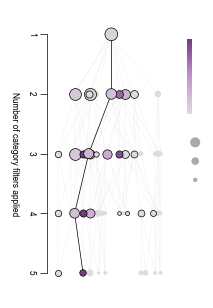

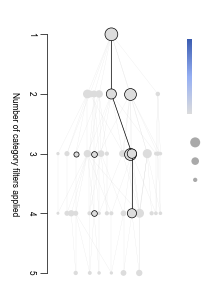

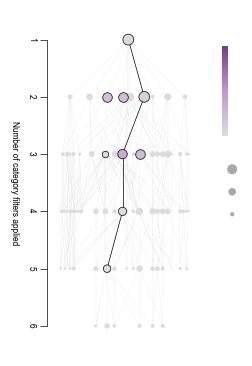

In [19]:
node_dfs = []
for t in trees_to_make:

    disease, sv_category = t[0], t[1]

    # extract the SVs in question
    subframework_results = framework_results.query(
        f'disease == "{disease}" & sv_category == "{sv_category}" & af_category == "singleton"'
    )

    if sv_category == "noncoding":
        func_cat = t[2]

        subframework_results = subframework_results.query(
            f'functional_category == "{func_cat}"'
        )

    tree_title = f"{disease} | {sv_category}"
    if sv_category == "noncoding":
        tree_title += f" | {func_cat}"

    path = label_dict[tree_title]

    # remove categories with negative point estimates
    if sv_category == "coding":
        subframework_results = subframework_results.query("point_estimate > 0")

    # define the categories in the tree
    categories = subframework_results["category_name"].tolist()

    ###########################################
    ### DEFINE DISTANCES BETWEEN CATEGORIES ###
    ###########################################

    data = category_svs[
        (category_svs["disease"] == disease)
        & (category_svs["category"].isin(categories))
        & (category_svs["sv_category"] == sv_category)
    ]

    data = data.pivot(columns="SV", index="category", values="value").fillna(0)
    data_values = data.values.astype(bool)

    # calculate jaccard distance based on SV overlap
    j_dist = pdist(data_values, metric="jaccard")
    j_dist = 1 - squareform(j_dist)

    # jaccard distance matrix for all pairwise comparisons
    j_dist = pd.DataFrame(j_dist, index=data.index, columns=data.index)

    #########################################
    ### DEFINE THE CATEGORY RELATIONSHIPS ###
    #########################################

    # dg is an adjacency matrix that defines our graph
    dg = nx.DiGraph()
    p_dict = parent_dicts[sv_category]

    # define parent-child relationships
    for i, cat_i in enumerate(categories):
        for j, cat_j in enumerate(categories):
            parent_rel = tree.classify_relationship(cat_i, cat_j, p_dict)

            # if one category is a parent of the other, add an edge,
            # with weight equaling their jaccard similarity
            if parent_rel and cat_i != cat_j:
                dg.add_edge(cat_i, cat_j, weight=j_dist.loc[cat_i, cat_j])

    # do transitive reduction - ie removes "superparent" relationships
    # so if A, B, and C are all connected, but the intended order is
    # A > B > C, it removes the edge A-C
    dg = nx.transitive_reduction(dg)

    ################################
    ### DETERMINE NODE POSITIONS ###
    ################################

    node_df = subframework_results.set_index("category_name").loc[list(dg.nodes)]

    # determine initial node positions based on hierarchy - this is what dot accomplishes
    node_positions = graphviz_layout(dg, prog="dot", args="-start=42")

    # redetermine node positions based on edge weights (jaccard similarity)
    force_positions = nx.spring_layout(dg, pos=node_positions, seed=42)

    # reset the x position depending category similarity.
    for cat, pos in node_positions.items():
        pos = (force_positions[cat][0], pos[1])
        node_positions[cat] = pos

    # before we trim or tighten the tree, store it for future reference
    master_node_df = node_df.copy()
    master_node_df[["x", "y"]] = [node_positions[cat] for cat in master_node_df.index]

    #######################################
    ### TRIM TREE BY JACCARD SIMILARITY ###
    #######################################

    bonf_cats = list(node_df.query("bonferroni_significant").index) + path

    cutoff = 0.4 if sv_category == "coding" else 0.5

    # custom code to "trim" the tree by jaccard similarity, keeping nodes with
    # a more significant p value
    dg, node_positions = tree.trim_tree_by_similarities(
        dg,
        node_df,
        node_positions,
        bonf_cats,
        j_dist,
        cutoff,
        "negative_log10_p_value",
        axis="y",
    )

    # remove nodes from our data based on this process
    # ie if nodes exactly overlap, the lower effect size one
    # is removed
    kept_nodes = list(dg.nodes)
    node_df = node_df.loc[kept_nodes]

    #########################
    ### TIGHTEN THE GRAPH ###
    #########################

    # neaten the tree, ie force similar categories on different levels
    # to be connected with a straight line
    dg, node_positions = tree.tighten_tree(
        dg, node_df, node_positions, 0.02, "negative_log10_p_value", axis="x"
    )

    # drop to these nodes and recreate positions
    kept_nodes = list(dg.nodes)
    node_df = node_df.loc[kept_nodes]

    ############################################
    ### DETERMINE OTHER NODE CHARACTERISTICS ###
    ############################################

    # and determine node size
    node_size = np.sqrt(node_df["SV_counts_cases"])
    node_eff = node_df["point_estimate"]

    # make node colors
    norm = norm_coding if sv_category == "coding" else norm_noncoding
    norm = mpl.colors.Normalize(
        vmin=norm[0],
        vmax=norm[1],
    )

    custom_cmap = colors.LinearSegmentedColormap.from_list(
        "custom",
        ["gainsboro", mc.palette[disease]["light2"], mc.palette[disease]["dark1"]],
        N=256,
    )

    # make the node colors and border sizes based on
    # p values. If significant, use the effect size to color
    node_colors = []
    border_sizes = []
    for i in range(len(node_eff)):
        eff = node_eff.iloc[i]
        bonf = node_df["bonferroni_significant"].iloc[i]
        pval = node_df["p_value"].iloc[i]

        if not bonf:
            node_colors.append("gainsboro")
        else:
            node_colors.append(custom_cmap(norm(eff)))

        # # determine the border size
        if pval < 0.05:
            border_sizes.append(0.50)
        else:
            border_sizes.append(0)

    node_colors = pd.Series(node_colors, index=node_df.index)
    border_sizes = pd.Series(border_sizes, index=node_df.index)

    #####################
    ### PLOT THE TREE ###
    #####################
    
    # The tree is plotted in layers, which allows finer control over which nodes
    # float to the top (similar categories will overlap)
    if sv_category == "coding":
        fig, ax = plt.subplots(1, 1, figsize=(1.6, 3.75), tight_layout=False)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(2.0, 4.5), tight_layout=False)

    # next, we order the plotting of the points. This is important for clarity in the tree.
    node_df["plot_level"] = 0

    # nominally significant categories are plotted above the rest
    sorted_sig_cats = node_df.query("p_value < 0.05").sort_values(by="point_estimate")
    node_df.loc[sorted_sig_cats.index, "plot_level"] = list(
        range(1, len(sorted_sig_cats) + 1)
    )

    max_level = node_df["plot_level"].max()
    node_df.loc[path, "plot_level"] = node_df["plot_level"].max() + 2

    # plot nodes separately to allow zorder control
    for zorder in node_df["plot_level"].unique():

        cats = node_df[node_df["plot_level"] == zorder].index
        sub_dg = dg.subgraph(cats)
        cats = list(sub_dg.nodes)

        # extract out the position data for these points
        sub_pos = {node: node_positions[node] for node in cats}
        sub_colors = node_colors.loc[cats]
        sub_sizes = node_size.loc[cats]
        sub_borders = border_sizes.loc[cats]

        # draw the network points
        collection = nx.draw_networkx_nodes(
            sub_dg,
            pos=sub_pos,
            node_color=sub_colors,
            node_size=sub_sizes * 3.25,
            edgecolors="black",
            linewidths=sub_borders,
            ax=ax,
        )
        collection.set_zorder(zorder)

    # draw the network edges
    edge_collection = nx.draw_networkx_edges(
        dg, pos=node_positions, edge_color="lightgrey", width=0.1, arrows=False, ax=ax
    )
    edge_collection.set_zorder(-1)

    # label the "y axis"
    aesthetics.strip_axis(ax=ax, y="ignore")

    # graphviz deletes axes, so we reset here
    y_levels = sorted(set(master_node_df["y"]))
    ax.spines["left"].set_bounds(min(y_levels), max(y_levels))
    ax.set_yticks(y_levels)
    ax.set_yticklabels(list(range(1, len(y_levels) + 1))[::-1])
    ax.tick_params(axis="y", reset=True, labelrotation=-90, right=False)
    ax.set_ylabel("Number of category filters applied", rotation=-90, labelpad=12)

    # add the colorbar
    cb = mpl.cm.ScalarMappable(norm=norm, cmap=custom_cmap)

    cbar_ax = fig.add_axes([1, 0.6, 0.03, 0.2])
    cbar = fig.colorbar(cb, cax=cbar_ax, orientation="vertical")

    cbar.ax.tick_params(size=0)
    cbar.set_ticklabels([])
    cbar.outline.set_visible(False)

    # create an axis for other labels
    point_labels = fig.add_axes([1, 0.4, 0.1, 0.15])
    point_labels.scatter(
        [0, 0, 0],
        [0, 0.5, 1],
        s=[np.sqrt(10) * 3, np.sqrt(100) * 3, np.sqrt(300) * 3],
        color="darkgrey",
        ec=None,
    )
    point_labels.set_ylim([-0.25, 1.25])
    aesthetics.strip_axis(ax=point_labels)

    ###################
    ### LABEL PATHS ###
    ###################

    title = f"{disease} | {sv_category}"
    if sv_category == "noncoding":
        title += f" | {func_cat}"

    # we explicitly plot the labelled path to ensure it is on top
    if title in label_dict:
        nodes = label_dict[title]
        subgraph = dg.subgraph(nodes)
        subpos = {k: v for k, v in node_positions.items() if k in nodes}

        # draw the edges using annotate
        prev_node = nodes[0]
        for n in nodes[1:]:

            source_pos = np.array(node_positions[prev_node])
            target_pos = np.array(node_positions[n])

            ax.plot(
                [source_pos[0], target_pos[0]],
                [source_pos[1], target_pos[1]],
                color="black",
                linewidth=0.5,
                zorder=node_df["plot_level"].max() - 1,
            )

            prev_node = n

    ###################
    ### SAVE FIGURE ###
    ###################

    out_name = f"{disease}-{sv_category}"
    if sv_category == "noncoding":
        out_name += f"-{func_cat}"

    fig.savefig(
        f"figures/{out_name}-tree-scaled.pdf",
        bbox_inches="tight",
    )

    node_dfs.append(master_node_df)
#     plt.close(fig)